Try nmf with all non negative features with grid search of c 


# NMF Modeling for player recomendations

non negative matrix factorization(NMF) is a feature reduction technique that decomposes a matrix into two smaller matricies that can be used to cluster features from the original matrix into topics as well as calculate the distance between samples in the original matrix to allow for recomendations between the closest samples to be created. I will be using NMF to generate player recomendations to find who has the cloest stats to  'Walker Zimmerman' and some of the other best players in the MLS 

In [3]:
## import packages and tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from soccerplots.radar_chart import Radar
from sklearn.decomposition import NMF 
from sklearn.preprocessing import Normalizer ,MaxAbsScaler
from sklearn.pipeline import make_pipeline
from utils import save_file,radar_compare 

In [30]:
## load data
df = pd.read_csv('../data/final_per_90_and_pAdj.csv')

In [31]:
## set index and drop negative and categotical columns 
X = df.set_index('player_name')

X = X.drop(columns= ['Base Salary','Player', 'Club',
                     'Nation', 'Position','fb_id', 'Squad_from_op','G-xG','np:G-xG'])
X.shape

(705, 100)

In [32]:
## select key features to input into NMF 
X = X[[ 'Tackle_pct_won', 'Nineties', 'xA',
       'Key_pass', 'Comp_prog', 'Total_Cmp', 'Total_Att', 'Total_Cmp_pct',
       'Total_Tot_Dist', 'Total_Prg_Dist', 'Short_Cmp', 'Short_Att',
       'Short_Cmp_pct', 'Medium_Cmp', 'Medium_Att', 'Medium_Cmp_pct',
       'Long_Cmp', 'Long_Att', 'Long_Cmp_pct', 'touches', 'touches_def_box',
       'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd',
       'touches_att_box', 'touch_live', 'dribble_Succ', 'dribble_Att',
       'dribble_Succ_pct', 'num_dribble_past', 'dribble_megs', 'carries',
       'carries_dist', 'carries_prog_dist', 'carries_prog', 'carries_att_3rd',
       'carries_att_box', 'miss_control', 'dispossed', 'recep_targ',
       'recep_succ', 'recept_pct', 'Fouls_drawn', 'Offsides', 'Crosses',
       'PK_won', 'Aerial_win_pct', 'Gls', 'Sh', 'SoT', 'SoT%', 'Sh/90',
       'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK', 'PKatt', 'xG', 'npxG',
       'npxG/Sh', 'pAdj_Total_tackles', 'pAdj_Tackles_Won',
       'pAdj_Tackles_Def_3rd', 'pAdj_Tackles_Mid_3rd', 'pAdj_Tackles_Att_3rd',
       'pAdj_Num_Dribblers_tackled', 'pAdj_Num_Dribbled_past', 
       'pAdj_Blocked_shots', 'pAdj_Blocked_SOT', 'pAdj_Blocked_pass',
       'pAdj_Interceptions', 'pAdj_Tackles_and_Ints', 'pAdj_Clearences',
       'pAdj_Yellow_cards', 'pAdj_Red_cards',
       'pAdj_Fouls', 'pAdj_def_interceptions', 
       'pAdj_PK_conceded', 'pAdj_OG', 'pAdj_Recoveries',
       'pAdj_Aerial_Duels_lost', 'lost_tackles', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 'avg_shrt+med_pass_pct', 'pct_long_balls',
       'prog_carry+lng_comp+crosses', 'attacking_touches']]
X = X.loc[(X['Nineties']>5)]
X.shape

(541, 90)

# Overview -

NMF or Non Negative Matrix Factorization is widley used for topic modeling and document clustering but there are many examples of NMF being used to cluster other kinds of datasets such as classifying Companies on extra finacial criteria.https://towardsdatascience.com/using-nmf-to-classify-companies-a77e176f276f .
    I am going  to use NMF to classify my MLS 2021 data set by the "topic" or ,grouping of player stats,that I will call "skill set group". I will use the skill sets to classify players in the league and then use a normalized version of the decomposed matrix to identify players who are closest to Key players Identified in my EDA such and "Nathan" and " "Zimmerman". At the end I should have all players classified by a key skill set and players closest to the target players identifed so show how francises could use NMF to I dentify players from around the globe that could fit into roles played by players in the MLS with wider data sets than I have access to at this time. 

# NMF matrix break down -
With the player matrix X being of n players(rows) and f features(player stats) (n x f)
and 
c = number of Skill set groups generated 

## Weight matrix - weights of each row for each skill set group or topic 
 players times skil set matrix 
#W = n x c 

## Hidden layer matric - hidden layer of feature value for each skill set group
player stat features times skill set group matrix
H = F x c

## Thus the matric multiplcation of W (weight)* H(hidden) approximates the original X player matrix

 W x H approximates X

## The W weight matrix is than used to find players closest to the target player in question

The distane between the topic values fo each player in the W matrix can be used to measure who is the most simular allowing for recomendations of players closest to the target player to be created.

The skill set group that has the higest ranking for each player is used to classify or label groups of players who are simular in their player stats features. 



In [33]:
# function to viz 
def display_features(H,W,feature_names, X_matrix ,no_top_features, no_top_players):
    """ visualize skill get group and highest ranked players in group """
    topics = {}
    # iterate through topics in topic-term matrix, 'H' aka
    # H is the hidden layer which is shape (F x C) feature times topic matrix
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_features - 1:-1]]))
        
        # add features to topics dictionary for later assesment. 
        
        topics[topic_idx] = [ (feature_names[i] + " (" + str(topic[i].round(2)) + ")") 
                             for i in topic.argsort()[:-(no_top_features+3) - 1:-1]]
        
        top_player_indicies = np.argsort( W[:,topic_idx] )[::-1][0:no_top_players]
        for p_index in top_player_indicies:
            
            print(p_index," ",X_matrix.index[p_index])
    
    return topics 



In [34]:

c = 8
# Create a MaxAbsScaler: scaler
transformer = MaxAbsScaler().fit(X)

# scale data
scaled_X= transformer.transform(X)

# Create an NMF model: nmf

nmf = NMF(n_components=c,max_iter=100000,init='nndsvda', l1_ratio=.05, random_state=42)

W = nmf.fit_transform(scaled_X)
H = nmf.components_
err = nmf.reconstruction_err_

print(nmf,'error :',err, '\n', ' W shape',W.shape,'H shape ',H.shape)

            
feature_names = X.columns.values
no_top_features = 4
no_top_players = 5

topics = display_features(H,W,feature_names, X, no_top_features,no_top_players)

NMF(init='nndsvda', l1_ratio=0.05, max_iter=100000, n_components=8,
    random_state=42) error : 17.50506871963302 
  W shape (541, 8) H shape  (8, 90)
Topic 0:
touches_mid_3rd (6.15) recep_succ (6.03) Total_Att (5.53) Total_Cmp (5.52)
313   Andreu Fontàs
351   Sebastian Berhalter
90   Michael Bradley
95   Andrés Ricaurte
108   Haris Medunjanin
Topic 1:
touches_att_box (3.11) SoT (2.9) pAdj_Yellow_cards (2.74) Sh (2.7)
45   Valentín Castellanos
192   Adam Buksa
147   Cristian Arango
106   Ola Kamara
337   Daniel Musovski
Topic 2:
pAdj_Tackles_Mid_3rd (2.21) pAdj_Total_tackles (1.99) pAdj_Tackles_Won (1.98) pAdj_Tackles_and_Ints (1.73)
409   Judson
462   Franco Ibarra
246   Eric Remedi
212   Yamil Asad
245   Dru Yearwood
Topic 3:
Crosses (1.74) attacking_touches (1.46) touches_att_3rd (1.37) carries_prog (1.35)
51   Yeferson Soteldo
0   Carles Gil
2   Emanuel Reynoso
136   Brian Rodríguez
6   Lucas Zelarayán
Topic 4:
pAdj_Clearences (1.27) pAdj_Blocked_shots (1.09) touches_def_3rd (0.93

In [36]:
tops = pd.DataFrame(topics,
#                     columns =['name of the 8 columns ']
                   )
tops

0                         1  \
0  touches_mid_3rd (6.15)    touches_att_box (3.11)   
1       recep_succ (6.03)                 SoT (2.9)   
2        Total_Att (5.53)  pAdj_Yellow_cards (2.74)   
3        Total_Cmp (5.52)                  Sh (2.7)   
4          carries (5.33)               npxG (2.64)   
5        Comp_prog (5.22)                  xG (2.5)   
6       recep_targ (5.21)                Gls (2.05)   

                                   2                         3  \
0        pAdj_Tackles_Mid_3rd (2.21)            Crosses (1.74)   
1          pAdj_Total_tackles (1.99)  attacking_touches (1.46)   
2            pAdj_Tackles_Won (1.98)    touches_att_3rd (1.37)   
3       pAdj_Tackles_and_Ints (1.73)       carries_prog (1.35)   
4  pAdj_Num_Dribblers_tackled (1.73)       dribble_Succ (1.17)   
5      pAdj_Num_Dribbled_past (1.66)        dribble_Att (1.17)   
6      pAdj_Tackle_int_blocks (1.58)    carries_att_3rd (1.15)   

                               4                             5  \
0         pAdj_Clearences (1.27)                Nineties (1.6)   
1      pAdj_Blocked_shots (1.09)          Total_Cmp_pct (1.35)   
2         touches_def_3rd (0.93)         Medium_Cmp_pct (1.32)   
3  pAdj_def_interceptions (0.78)  avg_shrt+med_pass_pct (1.31)   
4      pAdj_Interceptions (0.78)           Short_Cmp_pct (1.3)   
5  pAdj_Tackle_int_blocks (0.74)             recept_pct (1.13)   
6          Aerial_win_pct (0.71)            Long_Cmp_pct (1.1)   

                             6                             7  
0         Total_Cmp_pct (1.74)             recept_pct (0.82)  
1         Short_Cmp_pct (1.71)          Short_Cmp_pct (0.79)  
2  avg_shrt+med_pass_pct (1.7)  avg_shrt+med_pass_pct (0.79)  
3        Medium_Cmp_pct (1.69)         Medium_Cmp_pct (0.79)  
4            recept_pct (1.48)         pct_long_balls (0.71)  
5          Long_Cmp_pct (1.29)         touches_def_box (0.7)  
6      dribble_Succ_pct (1.24)               Long_Att (0.69)

In [37]:
def add_topics(X,W):
    df_new = X.copy()
    # Get the top predicted topic
    predicted_topics = [np.argsort(each)[::-1][0] for each in W]
    # Add to the df
    df_new['pred_topic_num'] = predicted_topics
    return df_new


df_new = add_topics(X,W)
df_new['pred_topic_num'].describe()

count    541.000000
mean       4.916821
std        1.335593
min        1.000000
25%        4.000000
50%        5.000000
75%        6.000000
max        7.000000
Name: pred_topic_num, dtype: float64

In [38]:
df_new['pred_topic_num'].value_counts()

5    209
4    105
6     85
7     74
3     43
2     13
1     12
Name: pred_topic_num, dtype: int64

In [18]:
df_new[df_new['pred_topic_num']==1]

Opposing_Poss  Opposing_Touches  Tackle_pct_won  Nineties  \
player_name                                                                   
Carlos Vela                50.2             20480            29.5      14.1   
Yeferson Soteldo           50.6             21171            27.1      19.3   
Brian Rodríguez            50.2             20480            27.7      11.3   
Tyler Pasher               54.9             21209            36.3       9.4   
Siad Haji                  47.4             18641            12.5       0.5   

                        xA  Key_pass  Comp_prog  Total_Cmp  Total_Att  \
player_name                                                             
Carlos Vela       0.340426  2.624113   5.531915  29.645390  40.992908   
Yeferson Soteldo  0.217617  1.865285   3.678756  32.227979  43.834197   
Brian Rodríguez   0.292035  2.035398   2.920354  18.761062  27.079646   
Tyler Pasher      0.234043  2.340426   4.468085  24.468085  37.340426   
Siad Haji         0.200000  2.000000   6.000000  21.000000  25.000000   

                  Total_Cmp_pct  ...  pAdj_Recoveries  pAdj_Aerial_Duels_lost  \
player_name                      ...                                            
Carlos Vela                72.3  ...         8.477394                0.353225   
Yeferson Soteldo           73.5  ...         7.405770                0.582476   
Brian Rodríguez            69.3  ...        11.459486                0.146916   
Tyler Pasher               65.5  ...         7.503840                0.511625   
Siad Haji                  84.0  ...        16.415428                0.000000   

                  lost_tackles  True_tackle_pct  pAdj_Tackle_int_blocks  \
player_name                                                               
Carlos Vela           0.470966        41.935484                3.296764   
Yeferson Soteldo      0.249633        23.076923                2.496327   
Brian Rodríguez       0.146916        18.750000                3.966745   
Tyler Pasher          0.852709        45.454545                2.899211   
Siad Haji             1.823936        33.333333                0.000000   

                  avg_shrt+med_pass_pct  pct_long_balls  \
player_name                                               
Carlos Vela                       83.95       20.242215   
Yeferson Soteldo                  81.50       16.312057   
Brian Rodríguez                   77.80       17.320261   
Tyler Pasher                      73.90       21.082621   
Siad Haji                         90.00       24.000000   

                  prog_carry+lng_comp+crosses  attacking_touches  \
player_name                                                        
Carlos Vela                         12.765957          49.574468   
Yeferson Soteldo                    19.740933          51.606218   
Brian Rodríguez                     11.327434          46.548673   
Tyler Pasher                        13.936170          41.914894   
Siad Haji                           14.000000          39.000000   

                  pred_topic_num  
player_name                       
Carlos Vela                    1  
Yeferson Soteldo               1  
Brian Rodríguez                1  
Tyler Pasher                   1  
Siad Haji                      1  

[5 rows x 101 columns]

In [39]:
transformer = Normalizer().fit(W)
normed_X= transformer.transform(W)
# can add back club and salary here 
normed_df = pd.DataFrame(normed_X,index=X.index.values)


In [40]:
# make df of only key features 
cdf = df[['player_name','Club',
       'Aerial_win_pct',
       'pAdj_Num_Dribblers_tackled',
       'pAdj_Num_Dribbled_past','pAdj_Tackles_and_Ints', 'pAdj_Clearences',
       'pAdj_Fouls','pAdj_Recoveries', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 
       'pct_long_balls', 'prog_carry+lng_comp+crosses',
       ]]

# def_df = cdf.loc[cdf['player_name'].isin(['Nathan Cardoso','Alan Franco','Andreu Fontàs','Andrés Reyes','Matt Besler'])]
cdf.rename(columns={'pAdj_Tackles_and_Ints':'Tackles_and_Ints','pAdj_Clearences':'Clearences','pAdj_Fouls':'Fouls',
                   'pAdj_Recoveries':'Recoveries',
                  'pAdj_Tackle_int_blocks':'Tackle_int_blocks','pAdj_Num_Dribblers_tackled':'Num_Dribblers_tackled',
                  'pAdj_Num_Dribbled_past':'Num_Dribbled_past'},inplace=True)

params = list(cdf.columns)[2:]

/Users/robertrustia/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [41]:
jm = normed_df.loc['Albert Rusnák']
sims = normed_df.dot(jm)

sims.nlargest(10)

Albert Rusnák           1.000000
Javier Eduardo López    0.972366
Diego Fagúndez          0.965011
Yimmi Chará             0.962488
Djordje Mihailovic      0.958533
Cole Bassett            0.954867
Maximiliano Moralez     0.953977
Cristian Roldan         0.953345
Cecilio Domínguez       0.952499
Hany Mukhtar            0.950801
dtype: float64

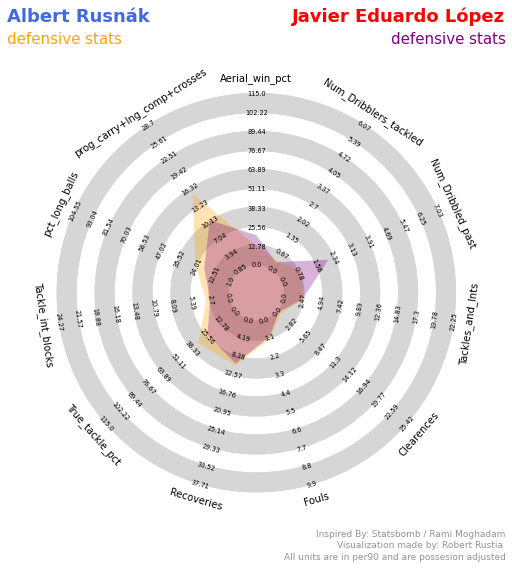

In [42]:
radar_compare('Albert Rusnák','Javier Eduardo López',params,cdf)

Having another creative attacking midfielder in Diego Fagundez as the closest player to Abert Rusnak helps validats the skill set groups created. 

In [43]:
tt = normed_df.loc['Tommy Thompson']
sims = normed_df.dot(tt)

sims.nlargest(10)

Tommy Thompson     1.000000
Zorhan Bassong     0.981675
Marco Farfan       0.960954
Marcos López       0.950946
Malte Amundsen     0.948435
Julian Araujo      0.944638
Pablo Bonilla      0.941431
DeJuan Jones       0.940822
Ema Twumasi        0.936313
Niko Hämäläinen    0.933341
dtype: float64

In [44]:
wz = normed_df.loc['Walker Zimmerman']
sims = normed_df.dot(wz)

sims.nlargest(10)

Walker Zimmerman     1.000000
Oswaldo Alanís       0.996763
Jonathan Mensah      0.996099
Ranko Veselinović    0.995324
Bill Tuiloma         0.993153
Tanner Beason        0.993146
Xavier Arreaga       0.991141
Robin Jansson        0.990437
Nkosi Burgess        0.989756
Jack Elliott         0.989574
dtype: float64

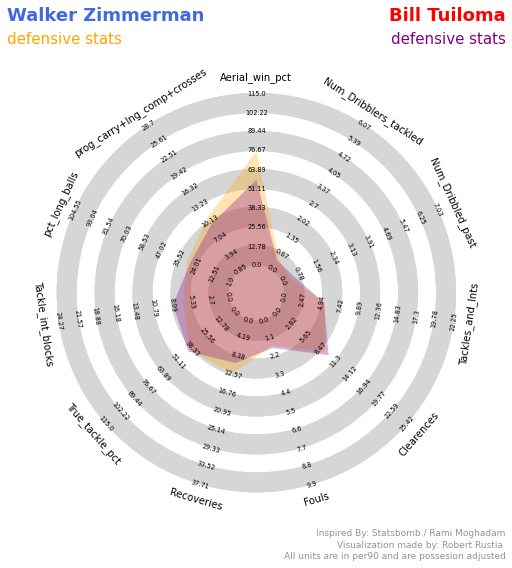

In [45]:
radar_compare('Walker Zimmerman','Bill Tuiloma',params,cdf)

In [38]:
jm = normed_df.loc['Jonathan Mensah']
sims = normed_df.dot(jm)

sims.nlargest(10)

Jonathan Mensah      1.000000
Tanner Beason        0.997402
Antonio Carlos       0.996732
Walker Zimmerman     0.996099
Oswaldo Alanís       0.995707
Ranko Veselinović    0.994264
Rudy Camacho         0.993281
Justen Glad          0.992826
Bill Tuiloma         0.992724
Xavier Arreaga       0.992455
dtype: float64

In [46]:
jm = normed_df.loc['Nathan Cardoso']
sims = normed_df.dot(jm)

sims.nlargest(10)

Nathan Cardoso          1.000000
Alan Franco             0.971050
Andrés Reyes            0.970232
Donovan Pines           0.965230
Francisco Calvo         0.959289
Johan Kappelhof         0.954601
Nick Hagglund           0.953494
Rodrigo Schlegel        0.950793
Gustavo Vallecilla      0.945636
Nicolas Isimat-Mirin    0.945454
dtype: float64

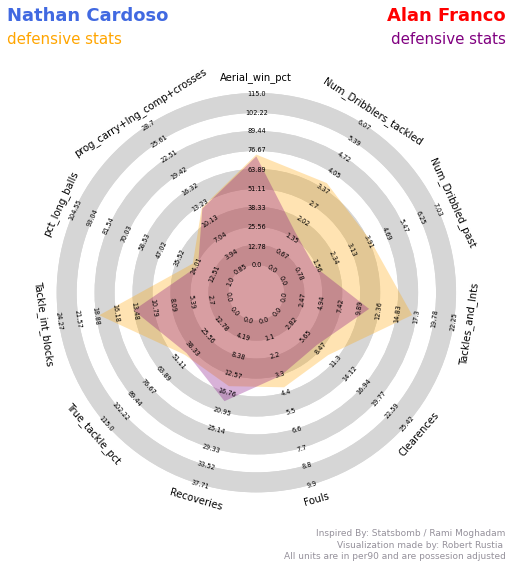

In [48]:
radar_compare('Nathan Cardoso','Alan Franco',params,cdf)

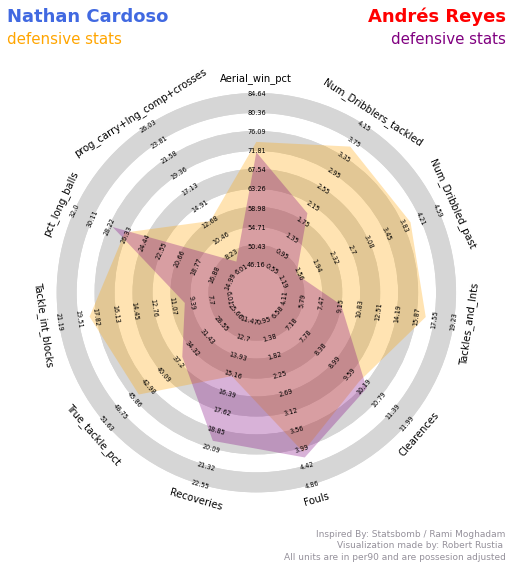

In [27]:
# make df of only key features 
cdf = df[['player_name','Club',
       'Aerial_win_pct',
       'pAdj_Num_Dribblers_tackled',
       'pAdj_Num_Dribbled_past','pAdj_Tackles_and_Ints', 'pAdj_Clearences',
       'pAdj_Fouls','pAdj_Recoveries', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 
       'pct_long_balls', 'prog_carry+lng_comp+crosses',
       ]]

def_df = cdf.loc[cdf['player_name'].isin(['Nathan Cardoso','Alan Franco','Andreu Fontàs','Andrés Reyes','Matt Besler'])]
def_df.rename(columns={'pAdj_Tackles_and_Ints':'Tackles_and_Ints','pAdj_Clearences':'Clearences','pAdj_Fouls':'Fouls',
                   'pAdj_Recoveries':'Recoveries',
                  'pAdj_Tackle_int_blocks':'Tackle_int_blocks','pAdj_Num_Dribblers_tackled':'Num_Dribblers_tackled',
                  'pAdj_Num_Dribbled_past':'Num_Dribbled_past'},inplace=True)

params = list(def_df.columns)[2:]
radar_compare('Nathan Cardoso','Andrés Reyes',params,def_df)
